# feature extraction

In [ ]:
import librosa
import pandas as pd
import csv
import os
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
import os

# Specify the new working directory path
new_directory = '/content/drive/MyDrive/Project'

# Change the working directory
os.chdir(new_directory)

# Display the updated working directory
updated_directory = os.getcwd()
print("Updated Working Directory:", updated_directory)


Updated Working Directory: /content/drive/MyDrive/Project


In [ ]:
import os
import csv
import librosa
import numpy as np

header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate tempo flux contrast flatness'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

genres = os.listdir('gtzan/audio_original')
for g in genres:
    genre_path = os.path.join('gtzan/audio_original', g)
    for filename in os.listdir(genre_path):
        songname = os.path.join(genre_path, filename)
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        flux = librosa.onset.onset_strength(y=y, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        flatness = librosa.feature.spectral_flatness(y=y)


        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)} {np.mean(tempo)} {np.mean(flux)} {np.mean(contrast)} {np.mean(flatness)}'
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())


In [ ]:

data = pd.read_csv('data.csv')
data = data.drop(['filename'],axis=1)

# Manualy drop the mfccs from 13 to 20 for training the model
data = data.drop(['zero_crossing_rate'],axis=1)
data = data.drop(['mfcc13'],axis=1)
data = data.drop(['mfcc14'],axis=1)
data = data.drop(['mfcc15'],axis=1)
data = data.drop(['mfcc16'],axis=1)
data = data.drop(['mfcc17'],axis=1)
data = data.drop(['mfcc18'],axis=1)
data = data.drop(['mfcc19'],axis=1)
data = data.drop(['mfcc20'],axis=1)

data.shape

(999, 22)

# logistic regression model

Train set accuracy: 0.74
Test set accuracy = 69.00%


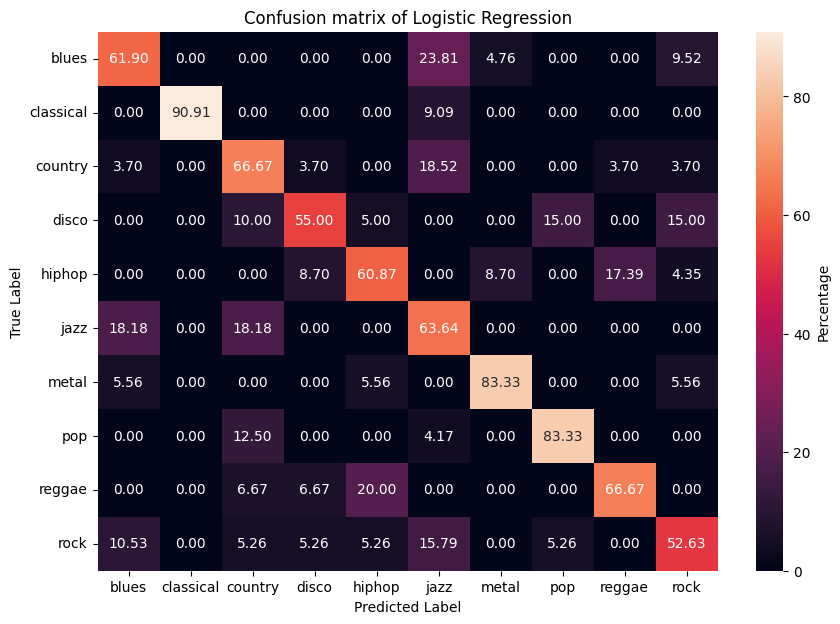

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

# Function to train the model using Logistic Regression
def log_reg_func(X_train, y_train, X_test, y_test, genre):
    logistic_classifier = LogisticRegression(max_iter=1000)
    logistic_classifier.fit(X_train, y_train)

    logistic_predictions = logistic_classifier.predict(X_test)
    logistic_accuracy = accuracy_score(y_test, logistic_predictions)

    logistic_cm = confusion_matrix(y_test, logistic_predictions)

    print("Train set accuracy: {:.2f}".format(logistic_classifier.score(X_train, y_train)))
    print("Test set accuracy = {:.2%}".format(logistic_accuracy))
    dump(logistic_classifier, 'model.pkl')
    plot_matrix(logistic_cm, "Confusion matrix of Logistic Regression", genre)

# Function to plot the confusion matrix with percentages
def plot_matrix(cm, title, genre):
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Normalize to percentages
    df_cm = pd.DataFrame(cm_percentage, index=genre, columns=genre)

    plt.figure(figsize=(10, 7))
    plt.title(title)
    sns.heatmap(df_cm, annot=True, fmt=".2f", cbar_kws={'label': 'Percentage'})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Scaling the dataset and Label encoding the label (genres)
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype=float))

genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

# Split the dataset with 80% for training set and 20% for test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Call the function
log_reg_func(X_train, y_train, X_test, y_test, encoder.classes_)


# SVM model

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.metrics import confusion_matrix
from sklearn import svm as svm_module
from sklearn.pipeline import Pipeline
from joblib import dump
import lightgbm as lgbm


# Function to train the model using SVM
def svm_model(params, X_train, y_train, X_test, y_test, title, genre):
    pipe_svm = Pipeline([
        ('scale', StandardScaler()),
        ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
        ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
        ('cls', svm_module.SVC())
    ])

    svm_model = GridSearchCV(pipe_svm, params, scoring='accuracy', cv=5)
    svm_model.fit(X_train, y_train)
    svm_pred = svm_model.predict(X_test)

    train_accuracy = svm_model.score(X_train, y_train)
    test_accuracy = svm_model.score(X_test, y_test)
    print("Train set accuracy: {:.2f}".format(train_accuracy))
    print("Test set accuracy: {:.2f}".format(test_accuracy))

    svm_cm = confusion_matrix(y_test, svm_pred)

    plot_matrix(svm_cm, title, genre)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

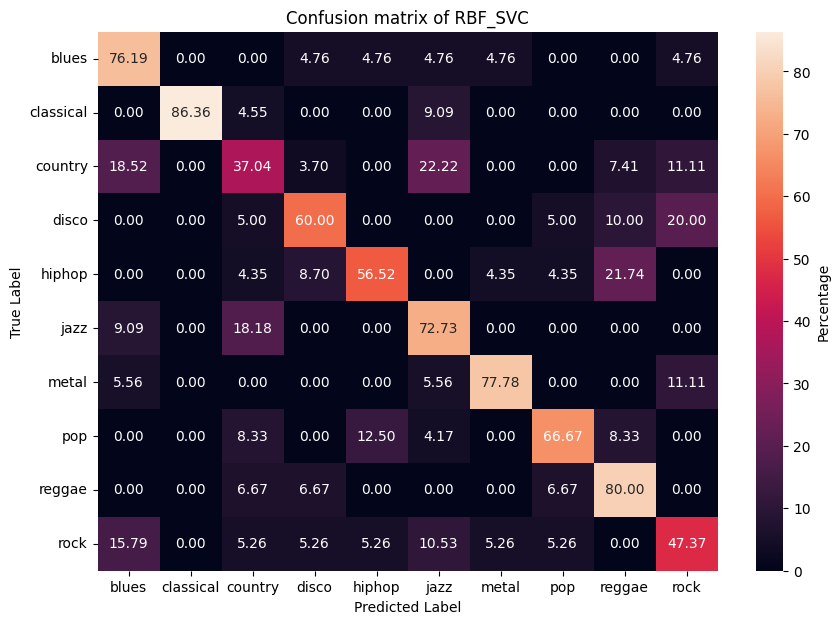

In [ ]:
# Define the parameters for the RBF kernel SVM
rbf_params = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['rbf'],
}

# Call the function
svm_model(rbf_params, X_train, y_train, X_test, y_test, "Confusion matrix of RBF_SVC", encoder.classes_)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

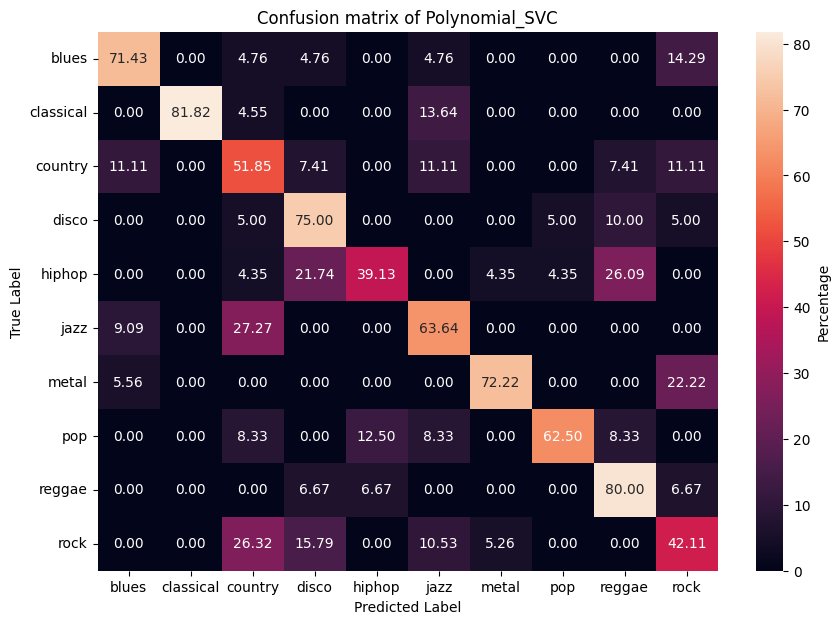

In [ ]:
#polynomial parameter SVC calling
poly_params = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['poly'],
}
svm_model(poly_params, X_train, y_train, X_test, y_test, "Confusion matrix of Polynomial_SVC",encoder.classes_)

# KNN

In [ ]:
# plotting for KNN
def plot_matrix(cm, title, genre):
    # Calculate  probabilities
    cm_prob = cm / cm.sum(axis=1, keepdims=True)

    # Create a DataFrame for the confusion matrix with probabilities
    df_cm = pd.DataFrame(cm_prob, index=["Blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
                         columns=["Blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"])

    # Plot the heatmap
    plt.figure(figsize=(12, 9))
    plt.title(title)
    sns.heatmap(df_cm, annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Train set accuracy: 0.75
Test set accuracy: 0.66


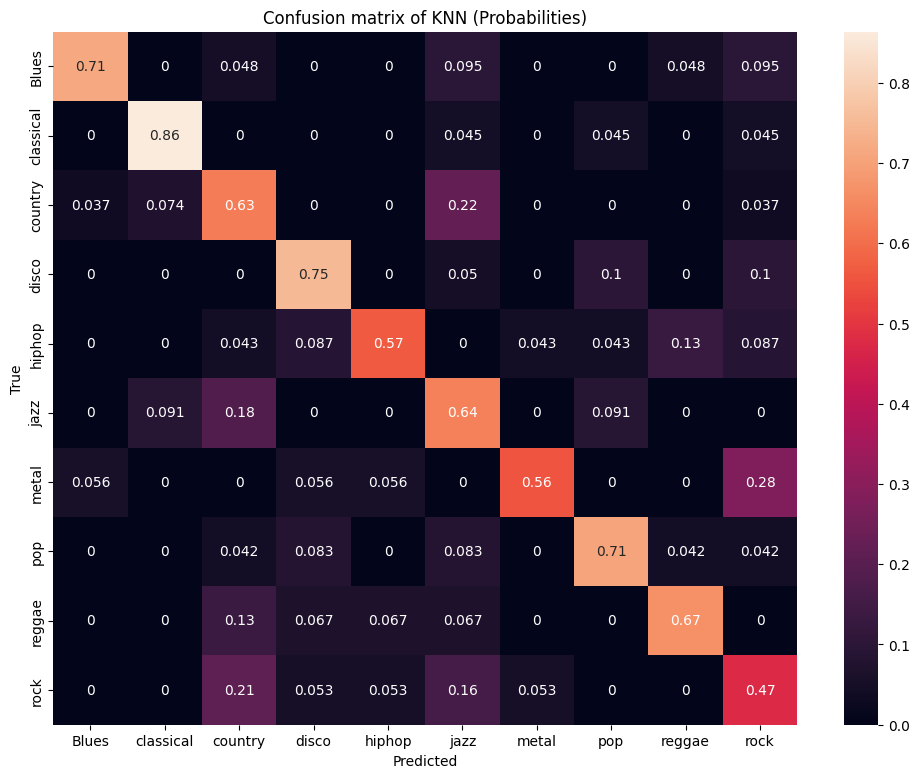

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score


# Training Model using KNN
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)

# Applying GridSearchCV to find the best k value
grid_params = {
    "n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15, 17],
    "weights": ["uniform"],
    "metric": ["euclidean", "manhattan"]
}

grid_knn = GridSearchCV(KNeighborsClassifier(), grid_params, verbose=1, cv=5, n_jobs=-1)
grid_knn.fit(X_train, y_train)
knn_pred = grid_knn.predict(X_test)

# Calculate train and test accuracies
train_accuracy = grid_knn.score(X_train, y_train)
test_accuracy = accuracy_score(y_test, knn_pred)

# Print train and test accuracies
print("Train set accuracy: {:.2f}".format(train_accuracy))
print("Test set accuracy: {:.2f}".format(test_accuracy))
grid_cm = confusion_matrix(y_test, knn_pred)


# Plotting the confusion matrix for KNN with probabilities
plot_matrix(grid_cm, "Confusion matrix of KNN (Probabilities)", "genre")
